<a href="https://colab.research.google.com/github/anilkeshwani/StatLearnProj/blob/master/Iason/Word2Vec_grid_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!apt install -qq enchant
!pip install pyenchant
!pip install emoji 
!pip install catboost
import nltk
nltk.download('stopwords')


In [87]:
import pandas as pd
import numpy as np
import json
import random
from tqdm import tqdm,tqdm_notebook
import enchant
from nltk import everygrams

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MaxAbsScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,make_scorer,fbeta_score
from sklearn.metrics import average_precision_score,plot_precision_recall_curve,precision_recall_curve
from sklearn.metrics import roc_auc_score,roc_curve, auc, brier_score_loss

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

from sklearn.decomposition import PCA


from gensim.models import KeyedVectors, Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import catboost as cb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from gensim.models import KeyedVectors, Word2Vec
import gensim.downloader as api

from google.colab import files # to read slang.txt until better solution is foun
uploaded = files.upload()

Saving slang.txt to slang (2).txt


In [ ]:
# Read in data (Raw copy for reference; copy for processing)

tweets = pd.read_csv('https://github.com/anilkeshwani/StatLearnProj/raw/master/Iason/climate_change_tweets_sample-2020-05-16-17-57.csv')
tweets.head()

,username,user_handle,date,retweets,favorites,text,label
0,WWF Climate & Energy,climateWWF,2020-04-28,11,22,Economic recovery and national climate pledges...,0
1,WWF Climate & Energy,climateWWF,2020-04-22,6,16,"In this difficult time, it’s hard to connect w...",0
2,WWF Climate & Energy,climateWWF,2020-04-01,43,69,"The decision to postpone # COP26, is unavoidab...",0
3,WWF Climate & Energy,climateWWF,2020-03-30,24,30,Japan - the world’s fifth largest emitter of g...,0
4,WWF Climate & Energy,climateWWF,2020-03-30,22,40,How can countries include # NatureBasedSolutio...,0


In [ ]:
# Clean Text Class


import csv  # for slang
import os
import re  # regex
import string  # punct
import numpy as np
import pandas as pd
import emoji  # for emoji
import nltk
import sklearn
from gensim.models import Word2Vec

from nltk.corpus import stopwords  # stopwords
from nltk.stem import PorterStemmer,SnowballStemmer  # stemming
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.base import BaseEstimator, TransformerMixin



class CleanText(BaseEstimator, TransformerMixin):
    
    def remove_mentions(self, input_text):
        '''
        Remove mentions, like @Mplamplampla
        '''
        return re.sub(r'@+', '', input_text)
    
    def remove_urls(self, input_text):
        '''
        Remove the urls mention in a tweet
        '''
        input_text  = ' '.join([w for w in input_text.split(' ') if '.com' not in w])
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        input_text = emoji.demojize(input_text)
        input_text = input_text.replace('_','')
        input_text = input_text.replace(':','')
        return input_text
    
    def possessive_pronouns(self, input_text):
        '''
        Remove the possesive pronouns, because otherwise after tokenization we will end up with a word and an s
        Example: government's --> ["government", "s"]
        '''
        return input_text.replace("'s", "")
    
    def characters(self, input_text):
        '''
        Remove special and redundant characters that may appear on a tweet and that don't really help in our analysis
        '''
        input_text = input_text.replace("\r", " ") # Carriage Return
        input_text = input_text.replace("\n", " ") # Newline
        input_text = " ".join(input_text.split()) # Double space
        input_text = input_text.replace('"', '') # Quotes
        return input_text
    
    def remove_punctuation(self, input_text):
        '''
        Remove punctuation and specifically these symbols '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
        '''
        punct = string.punctuation # string with all the punctuation symbols '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    
    def remove_digits(self, input_text):
        '''
        Remove numbers
        '''
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        '''
        Convert all the sentences(words) to lowercase
        '''
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        '''
        Remove stopwords (refers to the most common words in a language)
        '''
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        '''
        Reduce the words to their stem
        '''
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def encode_decode(self, input_text):
        '''
        Remove weird characters that are result of encoding problems
        '''
        return  " ".join([k.encode("ascii", "ignore").decode() for k in input_text.split(" ")])
    
    
    def translator(self, input_text):
        '''
        Transform abbrevations to normal words
        Example: asap --> as soon as possible
        '''
        input_text = input_text.split(" ")
        j = 0
        for _str in input_text:
            # File path which consists of Abbreviations.
            fileName = r"slang.txt"
            # File Access mode [Read Mode]
            accessMode = "r"
            with open(fileName, accessMode) as myCSVfile:
                # Reading file as CSV with delimiter as "=", so that 
                # abbreviation are stored in row[0] and phrases in row[1]
                dataFromFile = csv.reader(myCSVfile, delimiter="=")
                # Removing Special Characters.
                _str = re.sub('[^a-zA-Z0-9-_.]', '', _str)
                for row in dataFromFile:
                    # Check if selected word matches short forms[LHS] in text file.
                    if _str.upper() == row[0]:
                        # If match found replace it with its appropriate phrase in text file.
                        input_text[j] = row[1]
                myCSVfile.close()
            j = j + 1
        
        return(' '.join(input_text))
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = (X.apply(self.translator)
                    .apply(self.remove_mentions)
                    .apply(self.remove_urls)
                    .apply(self.emoji_oneword)
                    .apply(self.possessive_pronouns)
                    .apply(self.remove_punctuation)
                    .apply(self.remove_digits)
                    .apply(self.encode_decode)
                    .apply(self.characters)
                    .apply(self.to_lower)
                    .apply(self.remove_stopwords)
                    .apply(self.stemming))
        return clean_X
    
    def transform_no_stem(self, X, **transform_params):
        clean_X = (X.apply(self.translator)
                    .apply(self.remove_mentions)
                    .apply(self.remove_urls)
                    .apply(self.emoji_oneword)
                    .apply(self.possessive_pronouns)
                    .apply(self.remove_punctuation)
                    .apply(self.remove_digits)
                    .apply(self.encode_decode)
                    .apply(self.characters)
                    .apply(self.to_lower)
                    .apply(self.remove_stopwords))
        return clean_X

In [ ]:
# Text Cleaning
ct = CleanText()
tweets["text"] = ct.fit_transform(tweets.text)
tweets = tweets.loc[(~tweets.text.isnull()), :]
tweets.head()

,username,user_handle,date,retweets,favorites,text,label
0,WWF Climate & Energy,climateWWF,2020-04-28,11,22,econom recoveri nation climat pledg must desig...,0
1,WWF Climate & Energy,climateWWF,2020-04-22,6,16,difficult time hard connect natur world earthd...,0
2,WWF Climate & Energy,climateWWF,2020-04-01,43,69,decis postpon cop unavoid collect prioriti mus...,0
3,WWF Climate & Energy,climateWWF,2020-03-30,24,30,japan world fifth largest emitt greenhous gase...,0
4,WWF Climate & Energy,climateWWF,2020-03-30,22,40,countri includ naturebasedsolut climat plan nd...,0


In [ ]:
model_emb = api.load('word2vec-google-news-300')

[=================================================-] 98.2% 1633.1/1662.8MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
unvectorizable = set()
all_words = set()


def Word2VectorizeTweet(tweet):
    global all_words
    global unvectorizable
    
    tweet_vector = np.zeros(shape=(300,), dtype="float32")
    n_vectorizable = 0
    
    for word in tweet.split():
        try:
#             print(f"Adding {word} to word representation")
            tweet_vector = np.add(tweet_vector, model_emb.get_vector(word))
            all_words.add(word)
            n_vectorizable += 1
        except KeyError:
            d = enchant.Dict("en_US")
            words = [''.join(_ngram) for _ngram in everygrams(word) if d.check(''.join(_ngram)) and len(_ngram) > 1]
            if len(words) == 0:
                if word not in unvectorizable:
                    #print(f"Could not vectorize {word}")
                    unvectorizable.add(word)
            else:
                for w in words:
                    try:
                        tweet_vector = np.add(tweet_vector, model_emb.get_vector(w))
                        all_words.add(w)
                        n_vectorizable += 1
                    except KeyError:  
                        if w not in unvectorizable:
                            #print(f"Could not vectorize {w}")
                            unvectorizable.add(w)
    return (tweet_vector/n_vectorizable)

In [ ]:
tqdm.pandas(tqdm_notebook)
tweets["FastText"] = tweets.text.progress_apply(func=Word2VectorizeTweet)

100%|██████████| 18009/18009 [05:15<00:00, 57.16it/s]


In [ ]:
print(unvectorizable)

{'vra', 'rogu', 'luntz', 'rosi', 'zazzl', 'yuge', 'imbal', 'darwal', 'masc', 'stria', 'snc', 'gile', 'emend', 'osil', 'ruiz', 'decim', 'hurri', 'intoner', 'abash', 'olv', 'naki', 'sdg', 'arggh', 'unhq', 'isl', 'eecbg', 'dilig', 'siwi', 'vagu', 'instr', 'doomster', 'oeuvr', 'purpos', 'nsc', 'ibd', 'eik', 'whm', 'unep', 'ucd', 'unsaf', 'kundu', 'bounc', 'unstop', 'inspirit', 'nku', 'niro', 'pulkovo', 'sauc', 'sgp', 'iwd', 'transl', 'izzi', 'crowdfund', 'jimwal', 'undp', 'lvi', 'oho', 'unsg', 'pottiest', 'ettl', 'unsdg', 'igih', 'puzzl', 'pnwlng', 'chillest', 'olut', 'snp', 'fudg', 'landslid', 'judici', 'lyna', 'ipb', 'xis', 'raiyna', 'xrnyc', 'cdmx', 'glamour', 'sjcpb', 'pounc', 'cdu', 'whd', 'karoli', 'nra', 'strati', 'walru', 'boko', 'jaun', 'sludg', 'wrko', 'crazi', 'wwgdg', 'hemmer', 'famish', 'opes', 'ubc', 'fnc', 'dilut', 'elev', 'neap', 'unsur', 'olzak', 'to', 'bryce', 'nake', 'impend', 'ssrc', 'araujo', 'rbc', 'wfd', 'tdsb', 'scyth', 'derv', 'krazyvz', 'lints', 'zs', 'sulphur', '

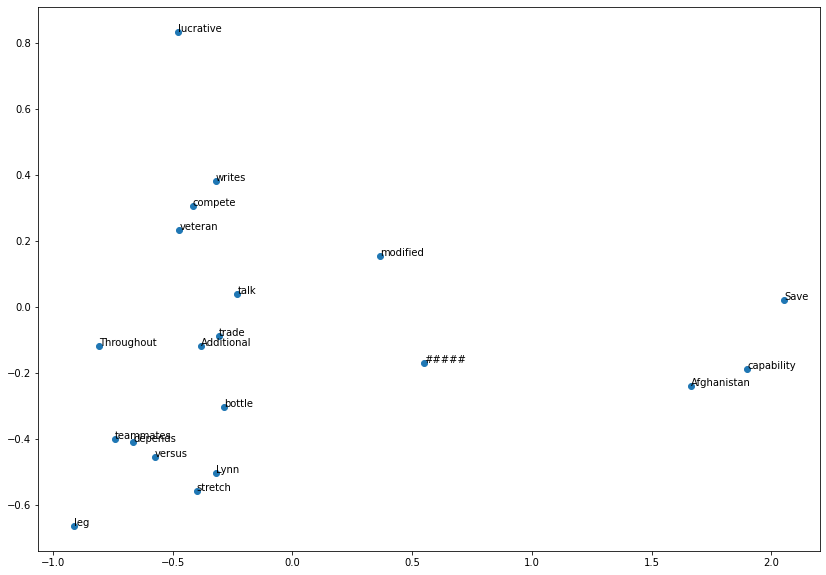

In [ ]:
plt.figure(figsize=(14, 10))

res = random.sample(range(1, len(all_words)), 20) 

vocab = model_emb[all_words]
pca = PCA(n_components=2)
pca_results = pca.fit_transform(vocab)

plt.scatter(pca_results[res, 0], pca_results[res, 1])

words = list(model_emb.vocab)

for i, word in enumerate(words):
    if i in res:
        plt.annotate(word[:], xy=(pca_results[i, 0], pca_results[i, 1]))
plt.show()

#### Remove NaN

In [ ]:
print(tweets.shape)
tweets['FastTextNan'] = tweets['FastText']
tweets['FastTextNan'] = np.array([k.tolist() for k in tweets.FastText.values]) 
print(tweets.shape)

(18009, 8)
(18009, 9)


In [ ]:
print(tweets.shape)

tweets.dropna(inplace=True)

print(tweets.shape)

(18009, 9)
(18008, 9)


In [ ]:
X = np.array([k.tolist() for k in tweets.FastText.values])

X_train, X_test, y_train, y_test = train_test_split(X, tweets.label.values, 
                                                    test_size=0.2, random_state=17, 
                                                    shuffle=True)


## Grid-Searches

In [ ]:
kfcv = KFold(n_splits=5,shuffle=True,random_state=101)


> Logistic Regression


In [ ]:
param_grid = {
            'penalty': ['elasticnet','l1','l2','none'],
            'C': [.001, .01, .1, 1, 10, 100, 1000],
            'solver': ['liblinear', "saga", "lbfgs"],
            'multi_class': ['ovr'],
            'max_iter' : [1000]
        }
grid_search_LR = GridSearchCV(estimator = LogisticRegression(random_state=17), param_grid = param_grid, cv=kfcv ,n_jobs = -1, verbose = 2)
grid_search_LR.fit(X_train,y_train)

print("## Best Logistic Regression parameters :", grid_search_LR.best_params_)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 383 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed: 12.1min finished


## Best Logistic Regression parameters : {'C': 10, 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'saga'}




> Random Forests





In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [1],
    'min_samples_split': [5, 10],
    'n_estimators': [50, 100, 300]
}
grid_search_RF = GridSearchCV(estimator = RandomForestClassifier(random_state=17), param_grid = param_grid, cv=kfcv ,n_jobs = -1, verbose = 5)
grid_search_RF.fit(X_train,y_train)

print("## Best Random Forest parameters :", grid_search_RF.best_params_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 13.8min finished


## Best Random Forest parameters : {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}




> Support Vector Machine





In [ ]:
# param_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
#                      'C': [1,10,100]},
#                     {'kernel': ['linear'], 'C': [1,10,100]}]
param_grid = {'kernel': ['linear'], 'C': [1,10,100]}
grid_search_SVM = GridSearchCV(estimator = SVC(random_state=17,probability=True), param_grid = param_grid, cv=kfcv ,n_jobs = -1, verbose = 5)
grid_search_SVM.fit(X_train,y_train)

print("## Best Super Vector Machines parameters with :", grid_search_SVM.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 26.0min finished


## Best Super Vector Machines parameters with : {'C': 10, 'kernel': 'linear'}


> Cat Boost

In [ ]:
param_grid = {'n_estimators':[100,250,500,1000],
              'depth':sp_randint(1,10),
              'learning_rate':[0.001,0.01,0.05,0.1,0.2,0.3], 
              'l2_leaf_reg':[1,5,10,100],
              'border_count':[5,10,20,50,100,200]}
n_HP_points_to_test = 15
grid_search_CB = RandomizedSearchCV(
    estimator=cb.CatBoostClassifier(random_state=17,thread_count=4,verbose=0), 
    param_distributions=param_grid, 
    n_iter=n_HP_points_to_test,
    scoring='accuracy',
    cv=kfcv,
    refit=True,
    random_state=17,
    n_jobs=-1,
    verbose=5)
grid_search_CB.fit(X_train,y_train)

print("## Best Cat Boost parameters :", grid_search_CB.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 13.6min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 29.3min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 30.2min finished


## Best Cat Boost parameters : {'border_count': 200, 'depth': 7, 'l2_leaf_reg': 100, 'learning_rate': 0.2, 'n_estimators': 1000}




> Gaussian Naives Bayes



In [ ]:
var_smoothing = [pow(10,k)/1000000000 for k in range(10)]
param_grid = {
           'var_smoothing': var_smoothing
        }
grid_search_NB = GridSearchCV(estimator = GaussianNB(), param_grid = param_grid, cv=kfcv ,n_jobs = -1, verbose = 5)
grid_search_NB.fit(X_train,y_train)

print("## Best Gaussian Naives Bayes parameters :", grid_search_NB.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.5s


## Best Gaussian Naives Bayes parameters : {'var_smoothing': 1e-09}


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.2s finished


Accuracy and visualisation of the results 

In [ ]:
def summary(list_best_grid,X_test,Y_test, word_representation):
    acc = [accuracy_score(bc.predict(X_test), Y_test) for bc in list_best_grid]
    df = pd.DataFrame(acc, index = ["Logistic Regression", "Random Forest", "CatBoost","Support Vector Machine", "Gaussian Naive Bayes"], columns = [word_representation])
    color = ["red", "orange", "blue", "pink", "green"]
    i = 0
    for clf in list_best_grid:
      y_score = clf.predict_proba(X_test)[:, 1]
      fpr, tpr, _ = roc_curve(Y_test, y_score)
      roc_auc = auc(fpr, tpr)
      plt.plot(fpr, tpr, color=color[i],lw=2, label=df.index.values.tolist()[i] + '(area = %0.2f)' % roc_auc)
      i +=1

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for ' + word_representation )
    plt.legend(loc="lower right")
    plt.show()
    return df

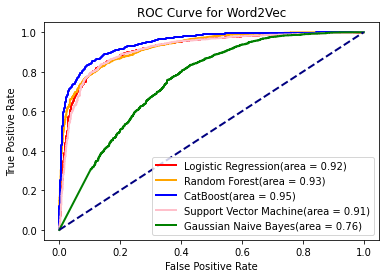

,Word2Vec
Logistic Regression,0.848418
Random Forest,0.833703
CatBoost,0.870627
Support Vector Machine,0.847585
Gaussian Naive Bayes,0.637424


In [ ]:
EST = [grid_search_LR.best_estimator_, 
          grid_search_RF.best_estimator_,  
          grid_search_CB.best_estimator_,
          grid_search_SVM.best_estimator_, 
          grid_search_NB.best_estimator_]
summary(EST, X_test,y_test, "Word2Vec")

## Custom majority vote model

In [ ]:
class Majority_vote():
    """
    averaging all models
    """
    def __init__(self,models,threshold=None):
        self.base_models = models
        if threshold:
            self.threshold = threshold
        else:
            self.threshold = 0.5
              
    
    def fit(self,X_train,y_train):
        for model in self.base_models:       
            model.fit(X_train,y_train)

    def predict_score(self,X):
        s = []
        for k,model in enumerate(self.base_models):
            pred = model.predict_proba(X)[:,1]
            s.append(pred)
        s = np.array(s)
        return(np.sum(s,axis=0)/len(self.base_models))
    
    def predict(self,X):
        score = self.predict_score(X)
        pred = np.zeros(X.shape[0])
        pred[score>=self.threshold] = 1
        return pred

![dd](https://miro.medium.com/max/700/1*EekXroXi99N05jcskdPsIg.png)

In [ ]:
# estimators = [RandomForestClassifier(**{'bootstrap': True,'max_depth': None,'max_features': 'log2',
#                                         'min_samples_leaf': 1,'min_samples_split': 10,'n_estimators': 300,
#                                         'random_state':17}),
#               SVC(**{'C': 100, 'gamma': 0.001, 'kernel': 'rbf','probability':True,'random_state':17}),
#               LogisticRegression(**{'C':1000,'max_iter':1000, 'multi_class':"ovr", 'solver':"saga",'penalty':'l1','random_state':17}),
#               cb.CatBoostClassifier(**{"border_count": 200, "depth": 6, "l2_leaf_reg": 10,
#                                        "learning_rate": 0.3, "n_estimators": 1000,'verbose':0,'random_state':17})]

estimators = EST

kfcv = KFold(n_splits=3,shuffle=True,random_state=101)

In [83]:
best = 0
threshold = 0.5


for t in tqdm_notebook([0.4,0.45,0.5,0.55,0.6]):

    score_accuracy = []
    for train_index, val_index in kfcv.split(X_train,y_train):
        XX_train, XX_val = X_train[train_index], X_train[val_index]
        yy_train, yy_val = y_train[train_index], y_train[val_index]
        clf = Majority_vote(estimators,threshold=t)
        clf.fit(XX_train,yy_train)
        pred = clf.predict(XX_val)
        accuracy = accuracy_score(yy_val,pred)
        score_accuracy.append(accuracy)
        
    if np.mean(score_accuracy) >= best:
        best = np.mean(score_accuracy)
        threshold = t

print(best)
print(threshold)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


KeyboardInterrupt: ignored

In [84]:
threshold = 0.5

clf = Majority_vote(estimators,threshold=threshold)
clf.fit(X_train,y_train)

In [85]:
def plot_figure(X,y,clf):
    '''Plots Precision-Recall & ROC curves'''

    y_score = clf.predict_score(X)
    average_precision = average_precision_score(y, y_score)

    print('Average precision-recall score: {0:0.2f}'.format(
          average_precision))




    fpr, tpr, _ = roc_curve(y, y_score)
    roc_auc = auc(fpr, tpr)

    #plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.grid()
    
    plt.show()

#######################

Accuracy: 0.8609
Precision: 0.8837
Recall: 0.8817
F1_score: 0.8827
F2_score: 0.8821
F5_score: 0.8817
AUC_score: 0.9271
1-Brier_score: 0.8904

#######################

Average precision-recall score: 0.94


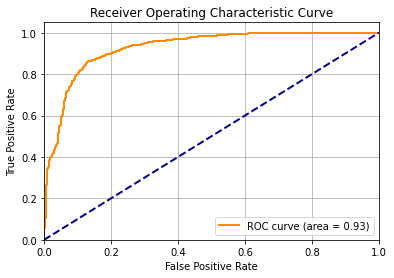

In [88]:
pred = clf.predict(X_test)
accuracy = accuracy_score(y_test,pred)
precision = precision_score(y_test,pred)
recall = recall_score(y_test,pred)
f1 = f1_score(y_test,pred)
f2 = fbeta_score(y_test,pred,beta=2)
f5 = fbeta_score(y_test,pred,beta=5)
y_score = clf.predict_score(X_test)
auc_score = roc_auc_score(y_test,y_score)
brier_score = brier_score_loss(y_test, y_score)


print('#######################\n')
print('Accuracy: {}'.format(round(accuracy,4)))
print('Precision: {}'.format(round(precision,4)))
print('Recall: {}'.format(round(recall,4)))
print('F1_score: {}'.format(round(f1,4)))
print('F2_score: {}'.format(round(f2,4)))
print('F5_score: {}'.format(round(f5,4)))
print('AUC_score: {}'.format(round(auc_score,4)))
print('1-Brier_score: {}'.format(round(1-brier_score,4)))
print()
print('#######################\n')


plot_figure(X_test,y_test,clf)